# Installing Required Packages

In [2]:
!pip install kagglehub
!pip install xgboost
!pip install kagglehub
!pip install pandas
!pip install scikit-learn


In [ ]:
import kagglehub
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.svm import SVC

In [ ]:
# Read CSV File 
filename = "universal_studio_branches.csv"
df = pd.read_csv(filename)



In [ ]:
# Combining title and review date

df['full_text'] = df['title'].fillna('') + ' ; ' + df['review_text'].fillna('')

In [ ]:
# Function to label reviews based on star rating
# Ratings 1-2 are labeled as "complaint", 3-5 as "non-complaint"
def label_review(row):
    if row <= 2:
        return "complaint"
    else:
        return "non-complaint"

# Apply the labeling function to the 'rating' column and create a new 'label' column
df['label'] = df['rating'].apply(label_review)

# Define features (review text) and labels (complaint/non-complaint)
X = df['review_text']
y = df['label']

# Split the dataset into training and testing sets (80% train, 20% test)
# Using stratify=y ensures the class distribution is preserved in both splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
# Create a machine learning pipeline with TF-IDF for feature extraction and SVM for classification
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words='english',      # Remove common English stop words
        ngram_range=(1, 2),        # Use unigrams and bigrams (e.g., "bad service")
        min_df=3,                  # Ignore words that appear in fewer than 3 documents
        max_df=0.9                 # Ignore words that appear in more than 90% of documents
    )),
    ('clf', SVC(
        kernel='linear',           # Use a linear kernel for the SVM
        C=1.0,                     # Regularization parameter
        class_weight='balanced'   # Automatically balance class weights (helpful for imbalanced data)
    ))
])

# Train the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict labels for the test data
y_pred = pipeline.predict(X_test)

# Print a classification report showing precision, recall, f1-score, and support for each class
print(classification_report(y_test, y_pred))

# Predict labels for a few new/unseen review texts
new_reviews = [
    "The ride was broken and the staff was rude",
    "Amazing experience! Will come back for sure.",
    "The lines were too long and disorganized",
    "I am utterly dissastified with the service"
]

# Make predictions using the trained pipeline
predictions = pipeline.predict(new_reviews)

# Print each review alongside its predicted label
for review, label in zip(new_reviews, predictions):
    print(f"Review: {review} --> Prediction: {label}")


               precision    recall  f1-score   support

    complaint       0.62      0.64      0.63       792
non-complaint       0.97      0.97      0.97      9389

     accuracy                           0.94     10181
    macro avg       0.79      0.80      0.80     10181
 weighted avg       0.94      0.94      0.94     10181

Review: The ride was broken and the staff was rude --> Prediction: complaint
Review: Amazing experience! Will come back for sure. --> Prediction: non-complaint
Review: The lines were too long and disorganized --> Prediction: non-complaint
Review: I am utterly dissastified with the service --> Prediction: complaint


We plan to integrate an exit survey at Universal Studios Singapore to collect real-time guest feedback. Using our trained machine learning model, we can automatically analyze responses and flag potential complaints early on. This enables the team to address issues proactively, before they turn into negative public reviews.

Despite the natural class imbalance in reviews, our model performs strongly—with an overall accuracy of 94%. It achieves a precision of 0.62 and recall of 0.64 for complaint detection, meaning it can reliably identify a significant portion of potentially dissatisfied guests. For non-complaints, the model is highly accurate with a 97% precision and recall.

This predictive capability is especially valuable given that online ratings on platforms like TripAdvisor heavily influence guest decisions. By acting on flagged complaints quickly, we can help maintain a strong reputation for USS and continue attracting new visitors.




# Topic Modelling about most complained about data

/var/folders/zp/tw07lk6n6vv6_m3l2s35cm3w0000gn/T/ipykernel_2494/1299510166.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complaints_df['full_review'] = complaints_df['title'].fillna('') + ' ' + complaints_df['review_text'].fillna('')


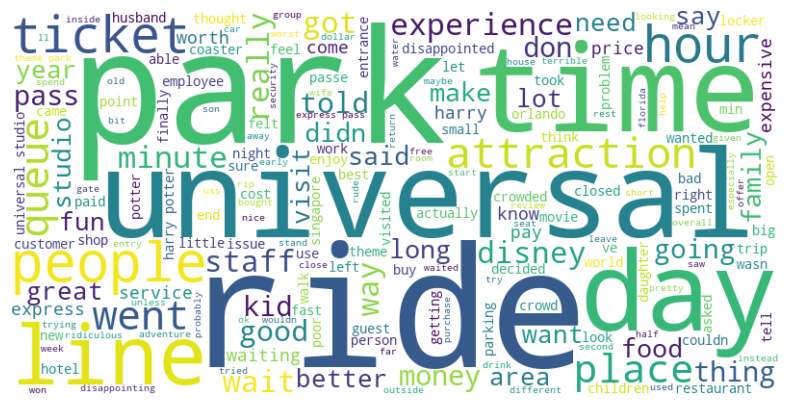

In [ ]:
# Filter out only reviews with ratings below 3 (1 and 2 stars), which we consider complaints
complaints_df = df[df['rating'] < 3]

# Combine the review title and text into a single column to provide more context for analysis
# Fill missing values with empty strings to avoid errors
complaints_df['full_review'] = complaints_df['title'].fillna('') + ' ' + complaints_df['review_text'].fillna('')

# Apply TF-IDF vectorization to convert text into numerical features
# Use unigrams, bigrams, and trigrams to capture more nuanced phrases
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 3))
tfidf_matrix = tfidf.fit_transform(complaints_df['full_review'])
feature_names = tfidf.get_feature_names_out()  # Get the list of terms

# Perform Latent Dirichlet Allocation (LDA) for topic modeling
# We specify 5 topics and a fixed random state for reproducibility
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tfidf_matrix)

# Extract top 8 key phrases for each topic discovered by LDA
topics = []
for idx, topic in enumerate(lda.components_):
    top_features = [feature_names[i] for i in topic.argsort()[-8:][::-1]]  # Top terms per topic
    topics.append({'Topic': f'Topic {idx + 1}', 'Top Phrases': ', '.join(top_features)})

# Manually assign descriptive labels to each topic based on the key phrases
labeled_topics = [
    {"Topic": "Crowded Park & Ride Experience", "Key Phrases": topics[0]['Top Phrases']},
    {"Topic": "Wait Times & Food Service Issues", "Key Phrases": topics[1]['Top Phrases']},
    {"Topic": "Value for Money Concerns", "Key Phrases": topics[2]['Top Phrases']},
    {"Topic": "Expensive & Poor Queuing System", "Key Phrases": topics[3]['Top Phrases']},
    {"Topic": "Cost vs. Disney Comparison", "Key Phrases": topics[4]['Top Phrases']}
]

# Create a DataFrame for easy viewing and further analysis
labeled_df = pd.DataFrame(labeled_topics)
labeled_df

# Generate a WordCloud for visualizing the most common words/phrases in the complaint reviews
text = ', '.join(tfidf.get_feature_names_out())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the WordCloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [ ]:
labeled_df


,Topic,Key Phrases
0,Crowded Park & Ride Experience,"park, ride, universal, rides, day, time, line, just"
1,Wait Times & Food Service Issues,"rides, park, day, ride, express, long, food, time"
2,Value for Money Concerns,"rides, updating, time money, long, money, expensive, harry potter really, potter really"
3,Expensive & Poor Queuing System,"rides, ride, park, expensive, queues, food, express, money"
4,Cost vs. Disney Comparison,"rides, money, park, long, time, disney, waste, worth"


To better understand the key pain points raised in low-rated reviews, we applied topic modeling using Latent Dirichlet Allocation (LDA) on reviews rated below 3 stars. By combining the title and text of each review, we enriched the context and used TF-IDF vectorization (with unigrams, bigrams, and trigrams) to capture detailed patterns in the language. LDA then helped uncover five distinct themes commonly mentioned in complaints, such as crowding, long wait times, and pricing concerns. These topics were manually labeled based on the top key phrases associated with each. Additionally, a word cloud was generated to visually highlight the most frequent terms, offering a quick overview of recurring issues in guest feedback.